<a href="https://colab.research.google.com/github/Alexkkir/face-points-detection/blob/main/cv_hw3_face_points_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from IPython.display import clear_output

In [3]:
! apt install tree
! pip install pytorch_lightning
clear_output()

In [4]:
import torch
import torchvision
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
# ! killall tensorboard
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

import numpy as np
import pandas as pd
from skimage import io, transform
import matplotlib
import matplotlib.pyplot as plt
from math import floor, ceil

import shutil
import requests
import functools
import pathlib
from pathlib import Path
import shutil
from tqdm.auto import tqdm
import os


matplotlib.rcParams['figure.figsize'] = (20, 5)

In [5]:
# Alternative
# %load_ext tensorboard
# %tensorboard --logdir lightning_logs

In [6]:
! killall tensorboard

In [7]:
# Get TensorBoard running in the background.
# Inspired by this answer.
LOG_DIR = 'lightning_logs'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [8]:
# Download and unzip ngrok
! wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
! unzip ngrok-stable-linux-amd64.zip
! ./ngrok authtoken 2Guo3eQeUVGdSqqedxD6ZQD0dUh_2i3S4pzGLhvSCHJo3ojTQ
clear_output()

In [11]:
url = "https://fall.cv-gml.ru/task_file/12/public_tests"
file = "data.zip"

In [12]:
import requests

cookies = {
    'session': '.eJwlzjFqBDEMheG7uE5hyRpL2ssMkiWREEhgZrcKuXsMaV7xF4_vp5115f3eHs_rlW_t_Ij2aEAqc4g5kpoYRXiVTZjkHQ8HSQCNKNY8AA6ChZCdhkvmjOo6iWzWRNeOVkBRAxAVBhKWwjJnFkQZonsnrN55qSIMc_dqG_K68_rXINMO677qfH5_5tdOWyQMuiEpixlGZzXwfXIQZfTkERAz2u8fxcI-Xg.Y1z7MA.IlLtKJ5SwECajQaH8UOrgYzg1GU',
}

headers = {
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
    'Accept-Language': 'ru,en;q=0.9',
    'Cache-Control': 'max-age=0',
    'Connection': 'keep-alive',
    # 'Cookie': 'session=.eJwlzjFqBDEMheG7uE5hyRpL2ssMkiWREEhgZrcKuXsMaV7xF4_vp5115f3eHs_rlW_t_Ij2aEAqc4g5kpoYRXiVTZjkHQ8HSQCNKNY8AA6ChZCdhkvmjOo6iWzWRNeOVkBRAxAVBhKWwjJnFkQZonsnrN55qSIMc_dqG_K68_rXINMO677qfH5_5tdOWyQMuiEpixlGZzXwfXIQZfTkERAz2u8fxcI-Xg.Y1z7MA.IlLtKJ5SwECajQaH8UOrgYzg1GU',
    'Referer': 'https://fall.cv-gml.ru/login',
    'Sec-Fetch-Dest': 'document',
    'Sec-Fetch-Mode': 'navigate',
    'Sec-Fetch-Site': 'same-origin',
    'Sec-Fetch-User': '?1',
    'Upgrade-Insecure-Requests': '1',
    'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.5005.167 YaBrowser/22.7.5.933 Yowser/2.5 Safari/537.36',
    'sec-ch-ua': '" Not A;Brand";v="99", "Chromium";v="102", "Yandex";v="22"',
    'sec-ch-ua-mobile': '?0',
    'sec-ch-ua-platform': '"Linux"',
}

response = requests.get('https://fall.cv-gml.ru/course/35/info', cookies=cookies, headers=headers)

In [13]:
def download(url, filename, **kwargs):    
    r = requests.get(url, **kwargs, stream=True, allow_redirects=True)
    if r.status_code != 200:
        r.raise_for_status()  # Will only raise for 4xx codes, so...
        raise RuntimeError(f"Request to {url} returned status code {r.status_code}")
    file_size = int(r.headers.get('Content-Length', 0))

    path = pathlib.Path(filename).expanduser().resolve()
    path.parent.mkdir(parents=True, exist_ok=True)

    desc = "(Unknown total file size)" if file_size == 0 else ""
    r.raw.read = functools.partial(r.raw.read, decode_content=True)  # Decompress if needed
    with tqdm.wrapattr(r.raw, "read", total=file_size, desc=desc) as r_raw:
        with path.open("wb") as f:
            shutil.copyfileobj(r_raw, f)

    return path

In [14]:
download(url, file, cookies=cookies, headers=headers)

  0%|          | 0/265024038 [00:00<?, ?it/s]

PosixPath('/content/data.zip')

In [15]:
shutil.unpack_archive('data.zip', 'data')

In [16]:
! tree data -aL 3

data
├── 00_test_img_gt
│   ├── gt.csv
│   └── img_shapes.csv
└── 00_test_img_input
    ├── test
    │   └── images
    └── train
        ├── gt.csv
        └── images

6 directories, 3 files


In [17]:
DATA_ROOT = Path('data')
images_path = DATA_ROOT / '00_test_img_input' / 'train' / 'images'
points_path = DATA_ROOT / '00_test_img_input' / 'train' / 'gt.csv'

In [18]:
class FacePointsDataset(Dataset):
    def __init__(self, images_path: Path, points_path: Path, transform = None, return_name=False):
        self.images_path = images_path
        self.points_df = pd.read_csv(points_path)
        self.transform = transform
        self.return_name = return_name

    def __len__(self):
        return len(self.points_df)

    @property
    def len(self):
        return self.__len__()
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        image_name = self.points_df.iloc[idx, 0]
        image = io.imread(str(self.images_path / image_name)).astype('float32') / 255
        if image.ndim == 2:
            image = np.dstack([image] * 3)
        points = self.points_df.iloc[idx, 1:].to_numpy().reshape(-1, 2).astype('float32')

        sample = dict(image=image, keypoints=points)

        if self.transform:
            sample = self.transform(image=image, keypoints=points)
            sample['keypoints'] = np.array(sample['keypoints']).astype('float32')

        if self.return_name:
            sample['name'] = image_name

        return sample

In [19]:
def show_points(image, points):
    plt.imshow(image)
    plt.scatter(points[:, 0], points[:, 1], c='r')

def show_points_batch(sample_batched, n=None, n_points=None):
    """Show image with landmarks for a batch of samples."""
    if n is None:
        n = sample_batched['keypoints'].shape[0]
    if n_points is None:
        n_points = sample_batched['keypoints'].shape[1]
    images_batch, landmarks_batch = \
            sample_batched['image'][:n, ...], \
            sample_batched['keypoints'][:n, ...]

    batch_size = len(images_batch)
    img_size_on_plot = 2.5
    n_img_width = 8
    n_img_height = ceil(batch_size / n_img_width)

    plt.figure(figsize=(
        ceil(n_img_width * img_size_on_plot),
        ceil(n_img_height * img_size_on_plot)
    ))
    for i in tqdm(range(batch_size)):
        plt.subplot(ceil(batch_size / n_img_width), n_img_width, i + 1)
        show_points(images_batch[i].permute(1, 2, 0), landmarks_batch[i])
    

def test_on_batch(model, loader, n=None):
    batch = next(iter(loader))
    device = next(model.parameters()).device
    preds = model(batch['image'].to(device)).cpu().detach()
    true = batch['keypoints']
    images = batch['image']

    if n is None:
        n = len(preds)

    print(((true[:n] - preds[:n]) ** 2).mean())

    show_points_batch({'image': images[:n], 'keypoints': preds[:n]})
    plt.suptitle('Predicted')
    plt.show()

    show_points_batch({'image': images[:n], 'keypoints': true[:n]})
    plt.suptitle('Ground truth')
    plt.show()
    return batch

def test_on_image(model, image):
    device = next(model.parameters()).device
    pred = model(image.unsqueeze(0).to(device)).cpu().detach()[0]
    show_points(np.zeros_like(image.permute(1, 2, 0)) + 1, pred)

In [20]:
def modify_dataset(images_path, points_path, dst_folder: Path, scale_size):
    shutil.rmtree(dst_folder, ignore_errors=True)
    transforms = A.Compose([
        A.Resize(scale_size, scale_size),
    ], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))

    dataset = FacePointsDataset(images_path, points_path, transforms, return_name=True)
    (dst_folder / 'images').mkdir(parents=True, exist_ok=True)
    df = {}
    for i, sample in tqdm(enumerate(dataset), total=len(dataset)):
        image = sample['image']
        points = sample['keypoints']
        name = sample['name']
        io.imsave(dst_folder / 'images' / name, (image * 255).astype('uint8'))
        df[name] = points.flatten()
    df = pd.DataFrame(df).T
    df.to_csv(dst_folder / 'points.csv')

MODIFIED = Path('rescaled')
modify_dataset(images_path, points_path, MODIFIED, 96)

  0%|          | 0/6000 [00:00<?, ?it/s]

In [22]:
class MyHorizontalFlip(A.HorizontalFlip):
    def __init__(self, p=0.5, *args, **kwargs):
        super().__init__(*args, p=1, **kwargs)
        swap_rule = {
            1: 4,
            2: 3,
            5: 10,
            6: 9,
            7: 8,
            12: 14,
            13: 13,
            11: 11
        }
          
        self.new_p = p
        swap_rule_2 = dict(zip(swap_rule.values(), swap_rule.keys()))
        swap_rule.update(swap_rule_2)
        swap_rule = np.array(sorted(list(swap_rule.items())))[:, 1] - 1
        self.swap_rule = swap_rule.astype('int')

    def __call__(self, *args, **kwargs):
        if np.random.rand() < self.new_p:
            sample = super().__call__(*args, **kwargs)
            sample['keypoints'] = np.array(sample['keypoints'])[self.swap_rule]
        else:
            sample = {'image': kwargs['image'], 'keypoints': kwargs['keypoints']}
        return sample

In [23]:
def inspect_points(sample):
    for i in range(14):
        ax = plt.subplot(2, 7, i + 1)
        plt.tight_layout()
        ax.set_title(i+1)
        show_points(sample['image'], sample['keypoints'][i:i+1])

# inspect_points(sample)
# plt.show()

In [31]:
transform = A.Compose([
    A.FromFloat(max_value=255, dtype='uint8'),
    MyHorizontalFlip(p=0.3),
    A.Rotate(p=0.35, limit=15),
    A.RingingOvershoot(p=0.2, blur_limit=(3, 7)),
    A.OneOf([
        A.HueSaturationValue(p=0.5),
        A.RGBShift(p=0.3),
        A.Compose([ 
            A.RandomBrightnessContrast(p=0.5),
            A.RandomGamma(p=0.5),
            A.CLAHE(p=0.5),
        ], p=0.1)
    ], p=0.4),
    A.Affine(scale=(0.85, 1), translate_percent=(0, 0.15), shear=(-8, 8), p=0.35),
    A.ToFloat(max_value=255),
    ToTensorV2()
], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))

val_fraction = 0.2
dataset = FacePointsDataset(MODIFIED / 'images', MODIFIED / 'points.csv', transform=transform, return_name=True)
val_size = int(dataset.len * val_fraction)
train_dataset, val_dataset = random_split(dataset, [dataset.len - val_size, val_size])

batch_size = 16
dl_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
dl_val = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [25]:
len(train_dataset), len(val_dataset)

(4800, 1200)

  0%|          | 0/16 [00:00<?, ?it/s]

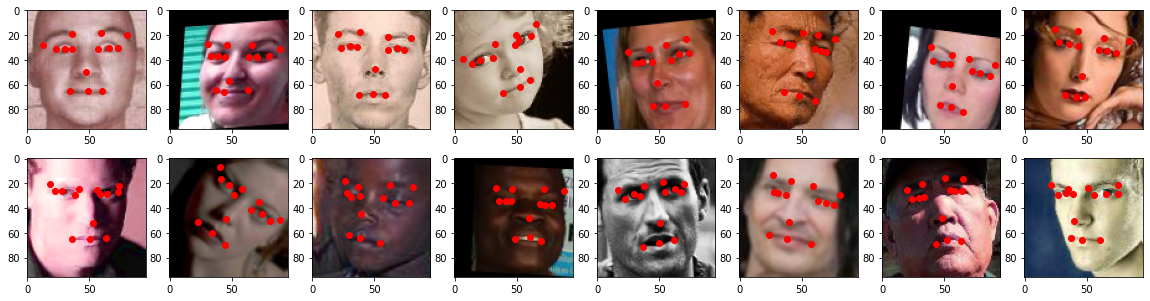

In [55]:
for i, batch in enumerate(dl_train):
    show_points_batch(batch)
    plt.show()
    break

In [51]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            # nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            # nn.BatchNorm2d(out_channels),
            nn.MaxPool2d(2, 2)
        )
    def forward(self, x):
        return self.cnn(x)

class Model(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.BatchNorm2d(3),
            Block(3, 64),
            Block(64, 128),
            Block(128, 256),
        )
        self.mlp = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(256 * 12 * 12, 128),
            nn.ReLU(),
            nn.Linear(128, 28),
        )

        self.loss = nn.MSELoss()
        # self.acc = nn.L1Loss()

    def forward(self, x):
        x = self.cnn(x)
        x = torch.flatten(x, 1)
        x = self.mlp(x)
        x = x.view(x.size(0), -1, 2)
        return x

    def training_step(self, batch, batch_idx):
        """the full training loop"""
        x, y = batch['image'], batch['keypoints']

        pred = self(x)
        loss = self.loss(pred, y)
        # acc = self.acc(pred, y)

        return {'loss': loss}

    def configure_optimizers(self):
        """ Define optimizers and LR schedulers. """
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=5e-4)
        # optimizer = torch.optim.SGD(self.parameters(), lr=1e-3, momentum=0.9)

        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, 
            mode='min', 
            factor=0.2, 
            patience=5, 
            verbose=True)
        
        lr_dict = {
            # REQUIRED: The scheduler instance
            "scheduler": lr_scheduler,
            # The unit of the scheduler's step size, could also be 'step'.
            # 'epoch' updates the scheduler on epoch end whereas 'step'
            # updates it after a optimizer update.
            "interval": "epoch",
            # How many epochs/steps should pass between calls to
            # `scheduler.step()`. 1 corresponds to updating the learning
            # rate after every epoch/step.
            "frequency": 1,
            # Metric to monitor for schedulers like `ReduceLROnPlateau`
            "monitor": "val_loss"
        } 

        return [optimizer], [lr_dict]

    # OPTIONAL
    def validation_step(self, batch, batch_idx):
        """the full validation loop"""
        x, y = batch['image'], batch['keypoints']

        pred = self(x)
        loss = self.loss(pred, y)
        # acc = self.acc(pred, y)

        return {'val_loss': loss}

    # OPTIONAL
    def training_epoch_end(self, outputs):
        """log and display average train loss and accuracy across epoch"""
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        # avg_acc = torch.stack([x['acc'] for x in outputs]).mean()

        print(f"| Train_loss: {avg_loss:.2f}" )

        self.log('train_loss', avg_loss, prog_bar=True, on_epoch=True, on_step=False)
        # self.log('train_acc', avg_acc, prog_bar=True, on_epoch=True, on_step=False)

    # OPTIONAL
    def validation_epoch_end(self, outputs):
        """log and display average val loss and accuracy"""
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        # avg_acc = torch.stack([x['val_acc'] for x in outputs]).mean()

        print(f"[Epoch {self.trainer.current_epoch:3}] Val_loss: {avg_loss:.2f}", end= " ")

        self.log('val_loss', avg_loss, prog_bar=True, on_epoch=True, on_step=False)
        # self.log('val_acc', avg_acc, prog_bar=True, on_epoch=True, on_step=False)

In [52]:
get_ipython().system_raw('./ngrok http 6006 &')
! sleep 2
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

MyModelCheckpoint = ModelCheckpoint(dirpath='runs/pl_classifier',
                                    filename='{epoch}-{val_loss:.3f}',
                                    monitor='val_loss', 
                                    mode='min', 
                                    save_top_k=1)

MyEarlyStopping = EarlyStopping(monitor = "val_loss",
                                mode = "min",
                                patience = 10,
                                verbose = True)

trainer = pl.Trainer(
    max_epochs=100,
    gpus=1,
    callbacks=[MyEarlyStopping, MyModelCheckpoint],
    log_every_n_steps=1
)

model = Model()

trainer.fit(model, dl_train, dl_val)

https://0502-34-91-137-22.ngrok.io


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:606: UserWarning: Checkpoint directory /content/runs/pl_classifier exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBL

Sanity Checking: 0it [00:00, ?it/s]

[Epoch   0] Val_loss: 2380.46 

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 28.638


[Epoch   0] Val_loss: 28.64 | Train_loss: 55.42


Validation: 0it [00:00, ?it/s]

[Epoch   1] Val_loss: 37.85 | Train_loss: 25.23


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 7.445 >= min_delta = 0.0. New best score: 21.193


[Epoch   2] Val_loss: 21.19 | Train_loss: 23.67


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 2.883 >= min_delta = 0.0. New best score: 18.310


[Epoch   3] Val_loss: 18.31 | Train_loss: 21.09


Validation: 0it [00:00, ?it/s]

[Epoch   4] Val_loss: 18.35 | Train_loss: 18.56


Validation: 0it [00:00, ?it/s]

[Epoch   5] Val_loss: 22.12 | Train_loss: 19.01


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 2.615 >= min_delta = 0.0. New best score: 15.694


[Epoch   6] Val_loss: 15.69 | Train_loss: 17.96


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 1.513 >= min_delta = 0.0. New best score: 14.181


[Epoch   7] Val_loss: 14.18 | Train_loss: 15.05


Validation: 0it [00:00, ?it/s]

[Epoch   8] Val_loss: 16.27 | Train_loss: 15.10


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.444 >= min_delta = 0.0. New best score: 13.737


[Epoch   9] Val_loss: 13.74 | Train_loss: 13.68


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.256 >= min_delta = 0.0. New best score: 13.482


[Epoch  10] Val_loss: 13.48 | Train_loss: 12.27


Validation: 0it [00:00, ?it/s]

[Epoch  11] Val_loss: 14.20 | Train_loss: 12.77


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 2.181 >= min_delta = 0.0. New best score: 11.300


[Epoch  12] Val_loss: 11.30 | Train_loss: 11.59


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.263 >= min_delta = 0.0. New best score: 11.037


[Epoch  13] Val_loss: 11.04 | Train_loss: 11.23


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.705 >= min_delta = 0.0. New best score: 10.332


[Epoch  14] Val_loss: 10.33 | Train_loss: 9.68


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.091 >= min_delta = 0.0. New best score: 10.241


[Epoch  15] Val_loss: 10.24 | Train_loss: 9.75


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.405 >= min_delta = 0.0. New best score: 9.836


[Epoch  16] Val_loss: 9.84 | Train_loss: 10.16


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.467 >= min_delta = 0.0. New best score: 9.369


[Epoch  17] Val_loss: 9.37 | Train_loss: 9.12


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.393 >= min_delta = 0.0. New best score: 8.977


[Epoch  18] Val_loss: 8.98 | Train_loss: 9.31


Validation: 0it [00:00, ?it/s]

[Epoch  19] Val_loss: 9.91 | Train_loss: 8.33


Validation: 0it [00:00, ?it/s]

[Epoch  20] Val_loss: 10.42 | Train_loss: 9.41


Validation: 0it [00:00, ?it/s]

[Epoch  21] Val_loss: 9.77 | Train_loss: 7.97


Validation: 0it [00:00, ?it/s]

[Epoch  22] Val_loss: 9.28 | Train_loss: 8.09


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 1.578 >= min_delta = 0.0. New best score: 7.398


[Epoch  23] Val_loss: 7.40 | Train_loss: 7.26


Validation: 0it [00:00, ?it/s]

[Epoch  24] Val_loss: 8.17 | Train_loss: 8.19


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.160 >= min_delta = 0.0. New best score: 7.238


[Epoch  25] Val_loss: 7.24 | Train_loss: 7.68


Validation: 0it [00:00, ?it/s]

[Epoch  26] Val_loss: 9.87 | Train_loss: 7.08


Validation: 0it [00:00, ?it/s]

[Epoch  27] Val_loss: 7.27 | Train_loss: 6.64


Validation: 0it [00:00, ?it/s]

[Epoch  28] Val_loss: 8.31 | Train_loss: 6.67


Validation: 0it [00:00, ?it/s]

[Epoch  29] Val_loss: 8.11 | Train_loss: 7.56


Validation: 0it [00:00, ?it/s]

[Epoch  30] Val_loss: 12.63 | Train_loss: 7.01


Validation: 0it [00:00, ?it/s]

[Epoch  31] Val_loss: 7.85 | Train_loss: 7.05
Epoch 00032: reducing learning rate of group 0 to 2.0000e-04.


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 1.540 >= min_delta = 0.0. New best score: 5.699


[Epoch  32] Val_loss: 5.70 | Train_loss: 5.62


Validation: 0it [00:00, ?it/s]

[Epoch  33] Val_loss: 6.36 | Train_loss: 5.41


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.084 >= min_delta = 0.0. New best score: 5.614


[Epoch  34] Val_loss: 5.61 | Train_loss: 5.07


Validation: 0it [00:00, ?it/s]

[Epoch  35] Val_loss: 5.87 | Train_loss: 5.18


Validation: 0it [00:00, ?it/s]

[Epoch  36] Val_loss: 5.85 | Train_loss: 5.04


Validation: 0it [00:00, ?it/s]

[Epoch  37] Val_loss: 5.80 | Train_loss: 4.96


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.189 >= min_delta = 0.0. New best score: 5.426


[Epoch  38] Val_loss: 5.43 | Train_loss: 4.83


Validation: 0it [00:00, ?it/s]

[Epoch  39] Val_loss: 5.84 | Train_loss: 4.74


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.176 >= min_delta = 0.0. New best score: 5.250


[Epoch  40] Val_loss: 5.25 | Train_loss: 4.69


Validation: 0it [00:00, ?it/s]

[Epoch  41] Val_loss: 5.60 | Train_loss: 4.81


Validation: 0it [00:00, ?it/s]

[Epoch  42] Val_loss: 5.60 | Train_loss: 4.73


Validation: 0it [00:00, ?it/s]

[Epoch  43] Val_loss: 5.67 | Train_loss: 4.55


Validation: 0it [00:00, ?it/s]

[Epoch  44] Val_loss: 5.59 | Train_loss: 4.51


Validation: 0it [00:00, ?it/s]

[Epoch  45] Val_loss: 5.75 | Train_loss: 4.84


Validation: 0it [00:00, ?it/s]

[Epoch  46] Val_loss: 5.58 | Train_loss: 4.73
Epoch 00047: reducing learning rate of group 0 to 4.0000e-05.


Validation: 0it [00:00, ?it/s]

[Epoch  47] Val_loss: 5.68 | Train_loss: 4.27


Validation: 0it [00:00, ?it/s]

[Epoch  48] Val_loss: 5.54 | Train_loss: 4.17


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.623 >= min_delta = 0.0. New best score: 4.627


[Epoch  49] Val_loss: 4.63 | Train_loss: 4.12


Validation: 0it [00:00, ?it/s]

[Epoch  50] Val_loss: 5.20 | Train_loss: 4.22


Validation: 0it [00:00, ?it/s]

[Epoch  51] Val_loss: 5.24 | Train_loss: 4.25


Validation: 0it [00:00, ?it/s]

[Epoch  52] Val_loss: 5.32 | Train_loss: 4.22


Validation: 0it [00:00, ?it/s]

[Epoch  53] Val_loss: 5.36 | Train_loss: 4.12


Validation: 0it [00:00, ?it/s]

[Epoch  54] Val_loss: 5.33 | Train_loss: 4.10


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.083 >= min_delta = 0.0. New best score: 4.545


[Epoch  55] Val_loss: 4.54 | Train_loss: 4.09


Validation: 0it [00:00, ?it/s]

[Epoch  56] Val_loss: 5.32 | Train_loss: 4.17


Validation: 0it [00:00, ?it/s]

[Epoch  57] Val_loss: 5.37 | Train_loss: 4.22


Validation: 0it [00:00, ?it/s]

[Epoch  58] Val_loss: 5.15 | Train_loss: 3.92


Validation: 0it [00:00, ?it/s]

[Epoch  59] Val_loss: 5.27 | Train_loss: 4.16


Validation: 0it [00:00, ?it/s]

[Epoch  60] Val_loss: 5.20 | Train_loss: 4.08


Validation: 0it [00:00, ?it/s]

[Epoch  61] Val_loss: 5.43 | Train_loss: 4.10
Epoch 00062: reducing learning rate of group 0 to 8.0000e-06.


Validation: 0it [00:00, ?it/s]

[Epoch  62] Val_loss: 5.12 | Train_loss: 3.93


Validation: 0it [00:00, ?it/s]

[Epoch  63] Val_loss: 5.13 | Train_loss: 3.96


Validation: 0it [00:00, ?it/s]

[Epoch  64] Val_loss: 5.10 | Train_loss: 4.00


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 10 records. Best score: 4.545. Signaling Trainer to stop.


[Epoch  65] Val_loss: 5.39 | Train_loss: 3.94


tensor(2.9450)


  0%|          | 0/16 [00:00<?, ?it/s]

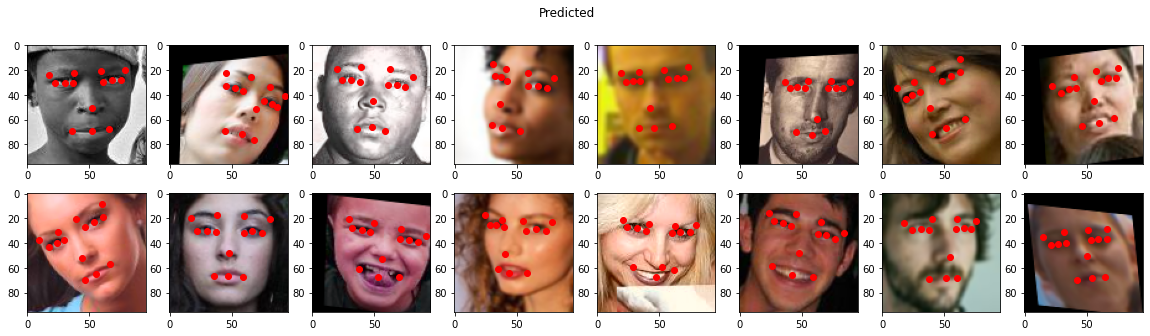

  0%|          | 0/16 [00:00<?, ?it/s]

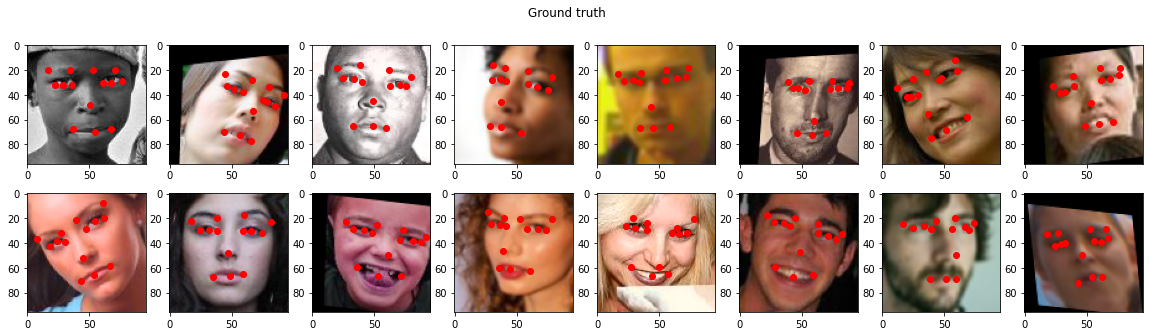

In [58]:
sample = test_on_batch(model, dl_val)

tensor(3.6071)


  0%|          | 0/64 [00:00<?, ?it/s]

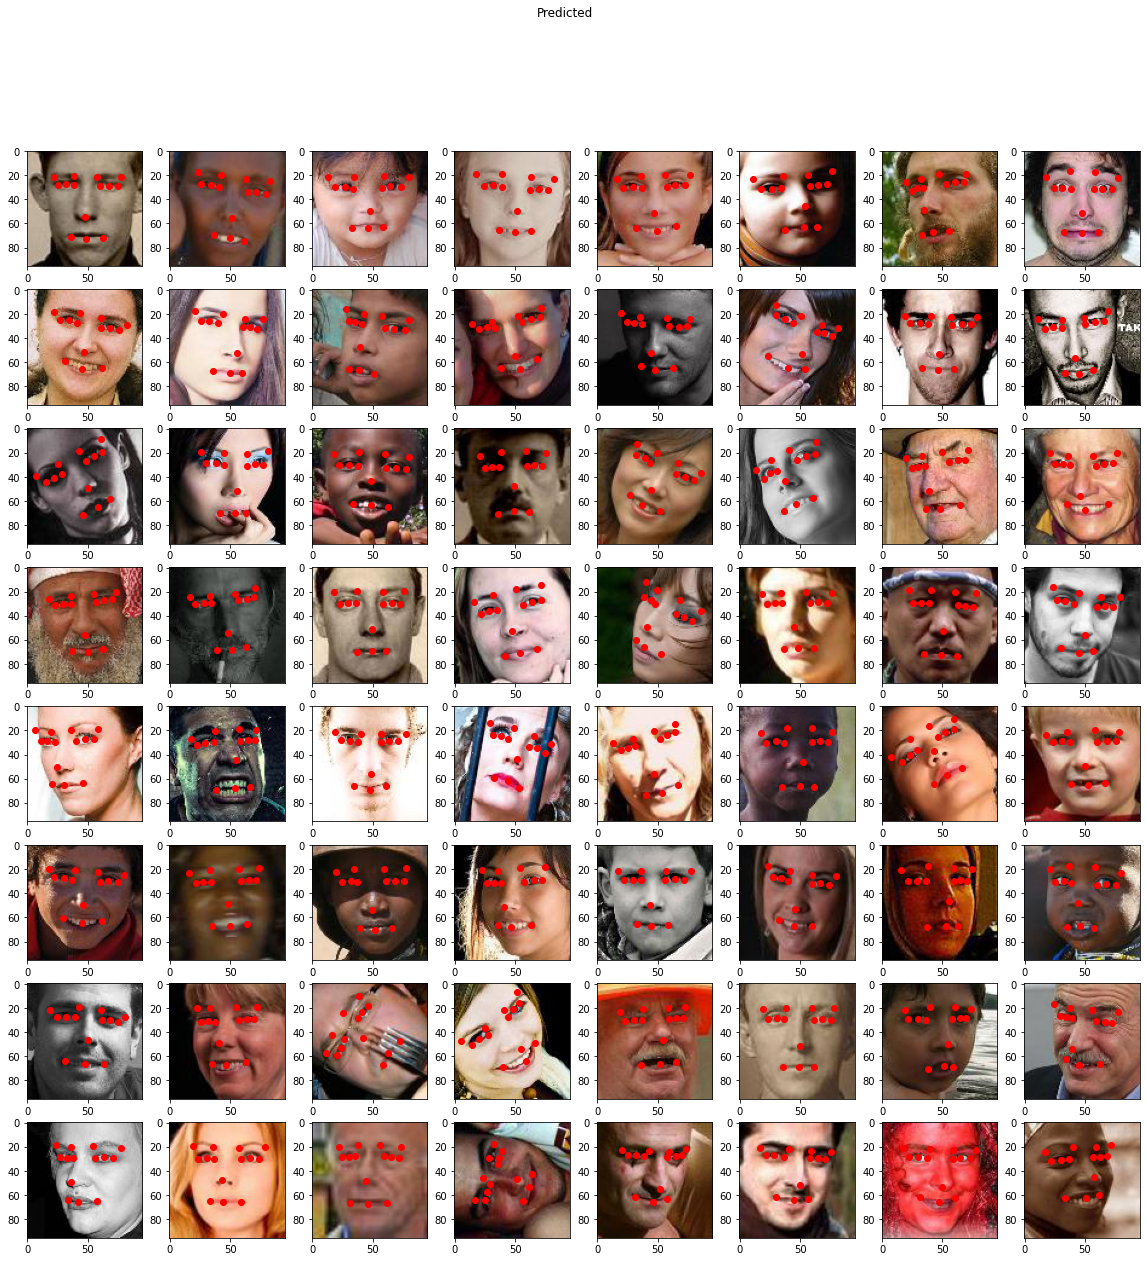

  0%|          | 0/64 [00:00<?, ?it/s]

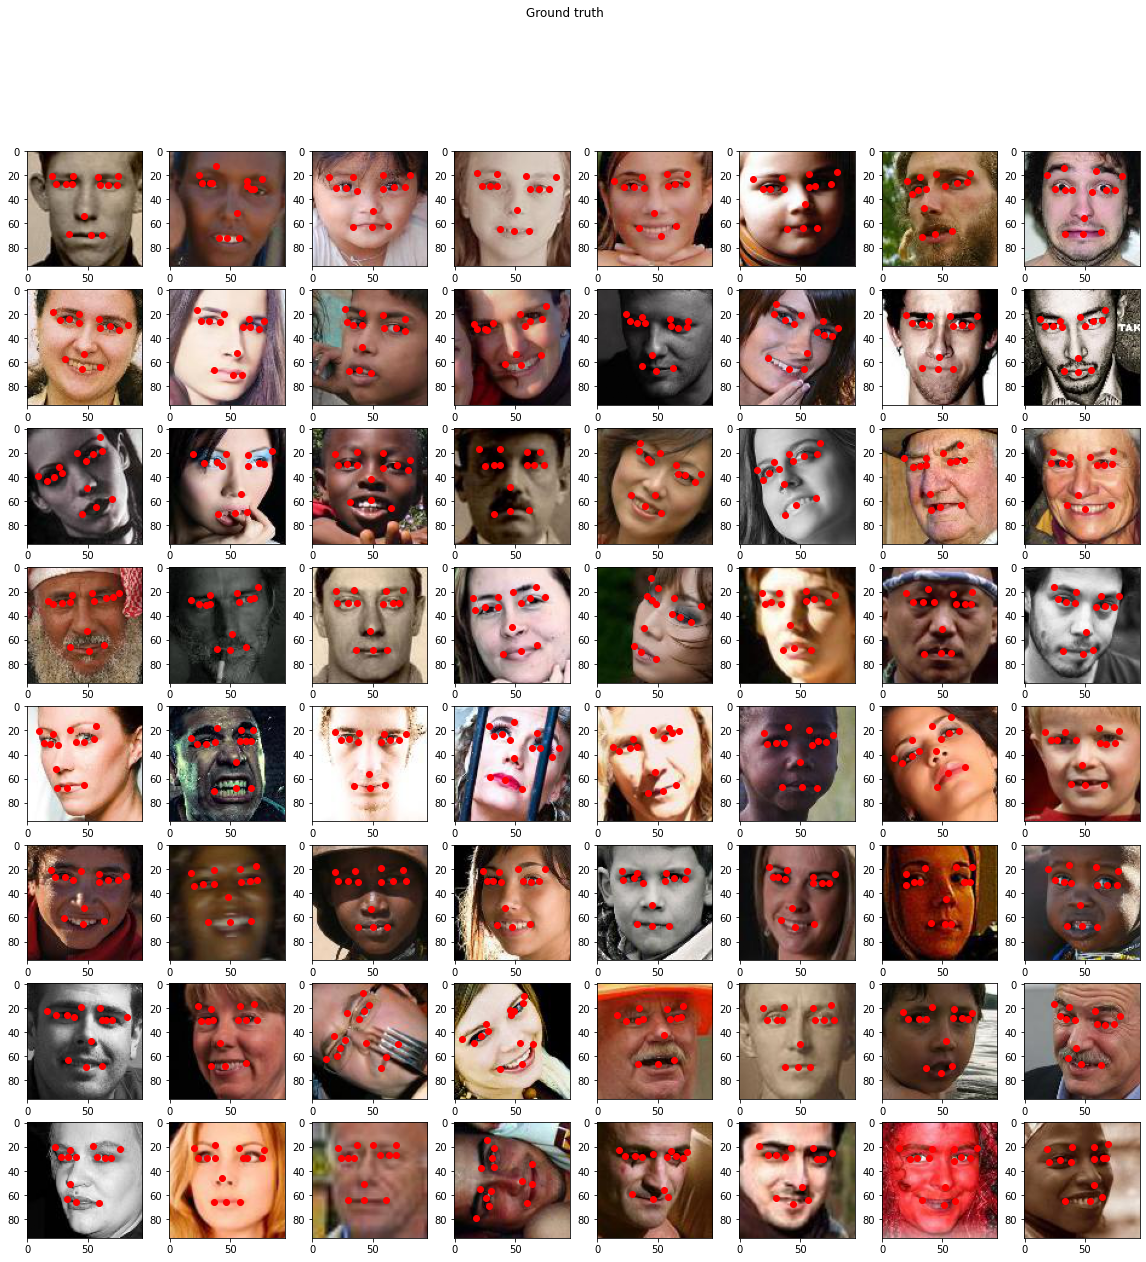

In [54]:
transform = A.Compose([
    ToTensorV2()
], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))


dataset_test = FacePointsDataset(MODIFIED / 'images', MODIFIED / 'points.csv', transform=transform, return_name=True)
dl_test = DataLoader(dataset_test, shuffle=True, batch_size=64)
sample = test_on_batch(model, dl_test)